<center>
    <h1><b>Nghiên cứu Khoa học</b></h1>
    <h2><b>Nghiên cứu sử dụng thị giác máy tính và học máy để giải bài toán Sudoku</b></h2>
</center>

---
**Sinh viên thực hiện:**
- Hồ Văn Đức - 1921011049
- Quách Thị Phương Hoa
- Nguyễn Thị Hằng

**Giáo viên hướng dẫn:**
- Đặng Văn Nam

### **Thư viện cần thiết**

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras

#### **Xây dựng hàm hiển thị ảnh**

In [2]:
def show_img(imgs, title=None, nrow=1, ncol=0, figsize=(0, 0)):
    
    if type(imgs) != list and type(imgs) != np.ndarray:
        imgs = [imgs]
    
    if type(imgs) == np.ndarray:
        if len(imgs.shape) < 4:
            imgs = [imgs]
    
    flag = False if title is None else True
    ncol = len(imgs) if ncol == 0 else ncol
    
    if figsize != (0, 0):
        plt.figure(figsize=figsize)
    
    for i in range(len(imgs)):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(imgs[i])
        if flag:
            plt.title(f"{title[i]}")
    plt.show()

### **Load ảnh**

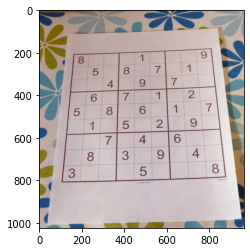

In [3]:
img = cv2.imread(r"./data/images/6978422072_33ac92fe1a_b.jpg")
imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show_img(imgRGB)

### **Xử lý ảnh**

In [4]:
WIDTH = 450
HEIGHT = 450

#### **Xây dựng hàm tiền xử lý ảnh**

Với các kỹ thuật:
- Đưa về ảnh xám
- Làm mờ ảnh
- Cắt ngưỡng

In [5]:
def preProcessing(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (15, 15), 1, 1)
    imgThresh = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)
    return imgThresh

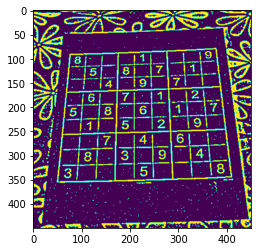

In [6]:
img_resized = cv2.resize(img, (HEIGHT, WIDTH))
thresh = preProcessing(img_resized)

show_img([thresh])

#### **Tìm các đường viền (contours)**

Đường viền là một đường cong bao quanh một vùng được phân biệt theo màu sắc hoặc độ sáng khác nhau trên ảnh.
- `cv2.findContours`: Dùng để tìm đường viền, hàm trả về list các đường viền được tìm thấy trong ảnh đầu vào.
- `cv2.drawContours`: Được sử dụng để vẽ các đường viền đã được tìm thấy trên ảnh.

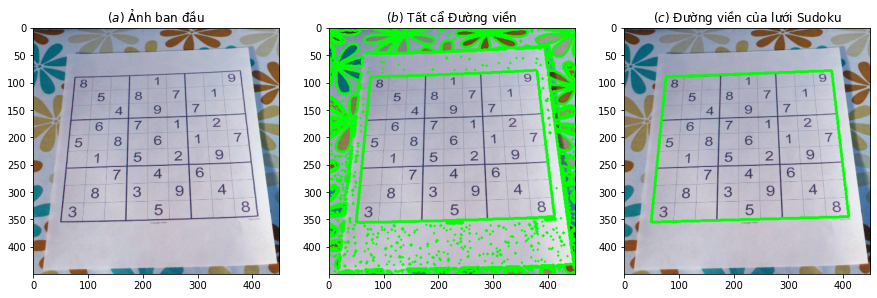

In [33]:
imgContours = img_resized.copy()
imgBigContours = img_resized.copy()
imgBigContours1 = img_resized.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3)
cv2.drawContours(imgBigContours1, [biggest], 0, (0, 255, 0), 3)

show_img([img_resized, imgContours, imgBigContours1], ["$(a)$ Ảnh ban đầu", "$(b)$ Tất cẩ Đường viền", "$(c)$ Đường viền của lưới Sudoku"], figsize=(15, 5))

#### **Tìm đường viền bao quanh lưới sudoku**

Đường viền bao quanh sudoku sẽ là đường viền có diện tích lớn nhất. Do đó ta cần xác định được đường viền có kích thước lớn nhất. Đây là đoạn code Python để tìm và sắp xếp lại các điểm của đường viền có diện tích lớn nhất trong danh sách contours:
- Hàm `getBiggestContour(contours)` nhận vào danh sách các contours contours và trả về đường viền có diện tích lớn nhất trong danh sách đó cùng với diện tích của nó. 
- Hàm `reorder(myPoints)` nhận vào numpy array myPoints chứa 4 điểm của hình chữ nhật cần sắp xếp lại, và trả về một numpy array mới chứa các điểm đã được sắp xếp lại theo đúng thứ tự: điểm trái trên, điểm phải trên, điểm trái dưới và điểm phải dưới.

In [30]:
def getBiggestContour(contours):
    biggest = np.array([[]])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True) #Xấp xỉ contours bằng các đoạn thẳng 
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area

def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

- `cv2.getPerspectiveTransform(pts1, pts2)`: Hàm này tính toán ma trận biến đổi để áp dụng cho ảnh gốc và thu được ảnh đã biến đổi. Ma trận này được tính bằng cách sử dụng các điểm của 2 hình chữ nhật

$$H = \begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \end{bmatrix}$$

$$\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = \begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$
- Trong đó:
    - H là ma trận biến đổi.
    - $(x,y)$ và $(x',y')$ lần lượt là tọa độ của một điểm trên hình ảnh ban đầu và điểm tương ứng trên hình ảnh đã biến đổi.
    - $a,b,c,d,e,f,g,h$ và $i$ là các tham số của ma trận biến đổi.
    - $w'$ là giá trị của $w$ sau khi biến đổi.

- `cv2.warpPerspective`: là một hàm trong thư viện OpenCV được sử dụng để thực hiện phép biến đổi hình học affine hoặc perspecive trên một ảnh.
$$dst(x',y') = \text{src}\left(\frac{H_{11} x' + H_{12} y' + H_{13}}{H_{31} x' + H_{32} y' + H_{33}}, \frac{H_{21} x' + H_{22} y' + H_{23}}{H_{31} x' + H_{32} y' + H_{33}}\right)$$

- Trong đó:
    - $\text{dst}$ là tọa độ điểm ảnh trên ảnh đích.
    - $\text{src}$ là tọa độ điểm ảnh trên ảnh gốc.

In [9]:
def get_Perspective(img, masked_num, location, inv=False):
    """Takes original image as input"""
    pts1 = np.float32(location)
    pts2 = np.float32([[0, 0], [WIDTH, 0], [0, HEIGHT], [WIDTH, HEIGHT]])
    
    width, height = WIDTH, HEIGHT
    if inv:
        pts1, pts2 = pts2, pts1
        width, height = img.shape[1], img.shape[0]
    
    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (width, height))
    return result

In [31]:
biggest, max_area = getBiggestContour(contours)

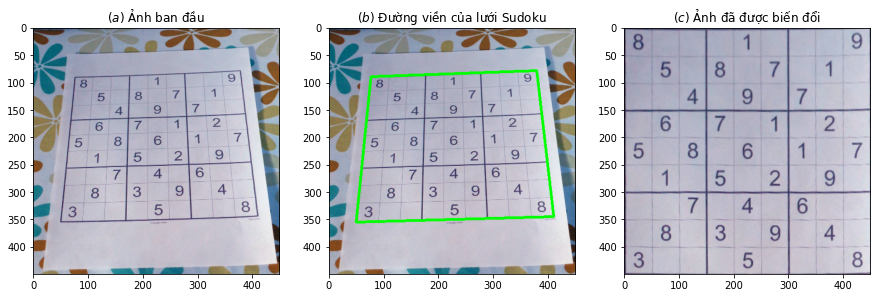

In [37]:
biggest, max_area = getBiggestContour(contours)

if biggest.size != 0:
    biggest = reorder(biggest)
    cv2.drawContours(imgBigContours, biggest, -1, (0, 255, 0), 255)
    imgPerspective = get_Perspective(img_resized, img_resized, biggest)
    imgWarpColored = cv2.cvtColor(imgPerspective, cv2.COLOR_BGR2RGB) 
    
show_img([img_resized, imgBigContours1, cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2RGB)], ["$(a)$ Ảnh ban đầu", "$(b)$ Đường viền của lưới Sudoku", "$(c)$ Ảnh đã được biến đổi"], figsize=(15, 5))

#### **Chia nhỏ lưới Sudoku**

In [38]:
def splitBoxes(img):
    rows = np.vsplit(img, 9)
    boxes = []
    for row in rows:
        cols = np.hsplit(row, 9)
        for box in cols:
            boxes.append(box)
    return boxes  

In [39]:
boxes = np.array(splitBoxes(imgWarpColored))

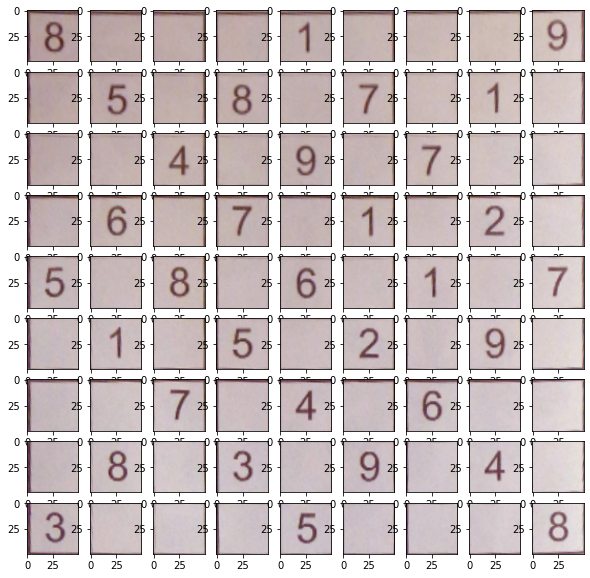

In [40]:
show_img(boxes, nrow=9, ncol=9, figsize=(10, 10))

### **Dự đoán các ô nhỏ**

Sử dụng model đã được huấn luyện đưa các ô đã được chia nhỏ vào

In [14]:
def getPredict(boxes, model):
    probs = []
    img = boxes.reshape(-1, 50, 50, 3)
    predict = model.predict(img)
    prob = np.max(predict, axis=1)
    probs.append(prob)
    classIndx = np.where(prob < 0.8, 0, np.argmax(predict, axis=1))
    return classIndx.reshape(9, 9), np.array(probs).reshape(9, 9)
model = keras.models.load_model('./mode_weight/lenet_model.h5')
pred, probs = getPredict(boxes, model)

3/3 [==============================] - 0s 16ms/step


In [15]:
grid = pred.reshape(9, 9)
grid_copy = grid.copy()

In [25]:
def display_predict_number(img, img_, num_pred, biggest):
    img_empty = np.zeros(img_.shape)
    for i in range(9):
        for j in range(9):
            if num_pred[i, j] != 0:
                cv2.putText(img_empty, str(num_pred[i, j]), org=(j*50+10, i*50+35), fontScale=2, thickness=2,
                            fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL, color=(0, 255, 0))
    
    inv = get_Perspective(img, img_empty, biggest, inv=True)
    combined = cv2.addWeighted(inv, 1, img, 0.5, 1, dtype=cv2.CV_8U)
    return np.clip(combined, 0, 255) 

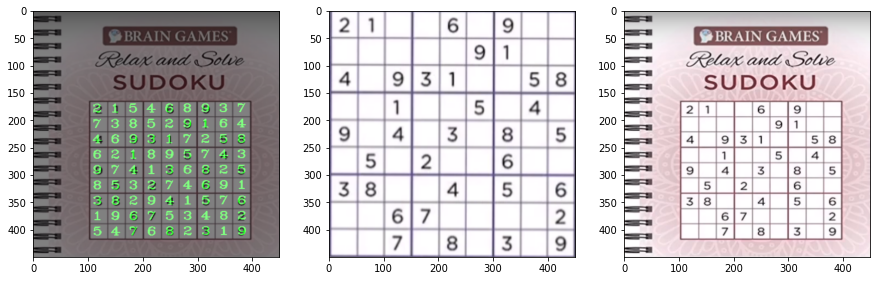

In [26]:
img_test = display_predict_number(img_resized, imgWarpColored, pred, biggest)
show_img([img_test, imgWarpColored, img_resized], figsize=(15, 5))

### **Giải Sudoku**

In [18]:
def valid(grid, num, pos) -> bool:
    # Check row
    for i in range(len(grid[0])):
        if grid[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(len(grid)):
        if grid[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if grid[i][j] == num and (i, j) != pos:
                return False

    return True

In [19]:
def find_empty(grid) -> None:
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] == 0:
                return (i, j)  # row, col

    return None

In [20]:
def solve() -> bool:
    global grid
    find = find_empty(grid)
    if not find:
        return True
    else:
        row, col = find

    for i in range(1, 10):
        if valid(grid, i, (row, col)):
            grid[row][col] = i

            if solve():
                return True

            grid[row][col] = 0

    return False

In [21]:
solve()
print(grid)

[[2 1 5 4 6 8 9 3 7]
 [7 3 8 5 2 9 1 6 4]
 [4 6 9 3 1 7 2 5 8]
 [6 2 1 8 9 5 7 4 3]
 [9 7 4 1 3 6 8 2 5]
 [8 5 3 2 7 4 6 9 1]
 [3 8 2 9 4 1 5 7 6]
 [1 9 6 7 5 3 4 8 2]
 [5 4 7 6 8 2 3 1 9]]


#### **Hiển thị kết quả**

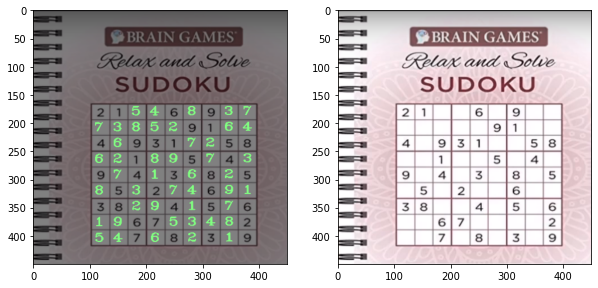

In [27]:
grid_show = np.where(grid == grid_copy, 0, grid) 
img_solved = display_predict_number(img_resized, imgWarpColored, grid_show, biggest)
show_img([img_solved, img_resized], figsize=(10, 5))